# Inspection of WEAVE first-light supercubes

## 1. Initialisation

### Imports

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c

### Template sky spectrum

built with ESO SkyCalc: <http://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC>

In [2]:
wavelength_SkyCalc, intensity_SkyCalc = np.loadtxt("ESO-SkyCalc_radiance.txt", unpack=True)

wavelength_SkyCalc *= 10  # nm -> Angstrom
intensity_SkyCalc *= 1e-8*(c.h*c.c/u.Angstrom).to_value(u.erg)/wavelength_SkyCalc  # ph/s/m^2/arcsec^2/micron -> erg/s/cm^2/arcsec^2/Angstrom

## 2. Read data

### Datacubes:

In [3]:
class Datacube(object):
    def __init__(self, filename):
        self.hdu = fits.open(filename)
        
        self.wcs = WCS(self.hdu[1].header)
        self.wavelength = self.wcs.spectral.pixel_to_world(np.arange(self.hdu[1].data.shape[0])).to_value(u.Angstrom)
        self.ngc7318a_x, self.ngc7318a_y = self.wcs.celestial.world_to_pixel(SkyCoord('22h35m56.7s', '+33d57m56s'))
        self.ngc7318b_x, self.ngc7318b_y = self.wcs.celestial.world_to_pixel(SkyCoord('22h35m58.4s', '+33d57m57s'))

        self.sensitivity = self.hdu[5].data
        self.ngc7318a = np.mean(self.hdu[1].data[:, int(self.ngc7318a_y-15):int(self.ngc7318a_y+15), int(self.ngc7318a_x-15):int(self.ngc7318a_x+15)], axis=(1, 2)) * self.sensitivity
        self.ngc7318b = np.mean(self.hdu[1].data[:, int(self.ngc7318b_y-15):int(self.ngc7318b_y+15), int(self.ngc7318b_x-15):int(self.ngc7318b_x+15)], axis=(1, 2)) * self.sensitivity
        self.sky = np.sum(self.hdu[3].data - self.hdu[1].data, axis=(1, 2)) * self.sensitivity / np.count_nonzero(self.hdu[6].data > 0)


In [4]:
LR_red = Datacube('data/supercube_2963102-001.fit')
LR_blue = Datacube('data/supercube_2963103-002.fit')
HR_red = Datacube('data/supercube_2963269.fit')
HR_blue = Datacube('data/supercube_2963270.fit')

## 3. Spectrophotometric calibration:
### Compute correction:

In [5]:

def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum = find_continuum(wavelength_SkyCalc, intensity_SkyCalc, 2);

for cube in [LR_red, LR_blue, HR_red, HR_blue]:
    wavelength, intensity = find_continuum(cube.wavelength, cube.sky, 3)
    correction =  np.interp(wavelength, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / intensity
    correction = np.interp(cube.wavelength, wavelength, correction)
    cube.correction = correction / np.median(correction)


In [6]:
'''
wavelength_red_HR_continuum, sky_red_HR_continuum = find_continuum(wavelength_red_HR, sky_red_HR, 3);
correction_red_HR =  np.interp(wavelength_red_HR_continuum, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / sky_red_HR_continuum
correction_red_HR = np.interp(wavelength_red_HR, wavelength_red_HR_continuum, correction_red_HR)
correction_red_HR /= np.median(correction_red_HR)

wavelength_blue_HR_continuum, sky_blue_HR_continuum = find_continuum(wavelength_blue_HR, sky_blue_HR, 3);
correction_blue_HR =  np.interp(wavelength_blue_HR_continuum, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / sky_blue_HR_continuum
correction_blue_HR = np.interp(wavelength_blue_HR, wavelength_blue_HR_continuum, correction_blue_HR)
correction_blue_HR /= np.median(correction_blue_HR)
'''

'\nwavelength_red_HR_continuum, sky_red_HR_continuum = find_continuum(wavelength_red_HR, sky_red_HR, 3);\ncorrection_red_HR =  np.interp(wavelength_red_HR_continuum, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / sky_red_HR_continuum\ncorrection_red_HR = np.interp(wavelength_red_HR, wavelength_red_HR_continuum, correction_red_HR)\ncorrection_red_HR /= np.median(correction_red_HR)\n\nwavelength_blue_HR_continuum, sky_blue_HR_continuum = find_continuum(wavelength_blue_HR, sky_blue_HR, 3);\ncorrection_blue_HR =  np.interp(wavelength_blue_HR_continuum, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / sky_blue_HR_continuum\ncorrection_blue_HR = np.interp(wavelength_blue_HR, wavelength_blue_HR_continuum, correction_blue_HR)\ncorrection_blue_HR /= np.median(correction_blue_HR)\n'

In [7]:
lines = {}
lines['OII_3726'] = [3726.032, 3717.0, 3737.0]
lines['OII_3729'] = [3728.815, 3717.0, 3737.0]
lines['NeIII_3869'] = [3869.060, 3859.0, 3879.0]
lines['H_delta'] = [4101.734, 4092.0, 4111.0]
lines['H_gamma'] = [4340.464, 4330.0, 4350.0]
lines['OIII_4363'] = [4363.210, 4350.0, 4378.0]
lines['H_beta'] = [4861.325, 4851.0, 4871.0]
lines['OIII_4959'] = [4958.911, 4949.0, 4969.0]
lines['OIII_5007'] = [5006.843, 4997.0, 5017.0]
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

#wavelength_bins = np.array(lines['H_alpha'])
#indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
#indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


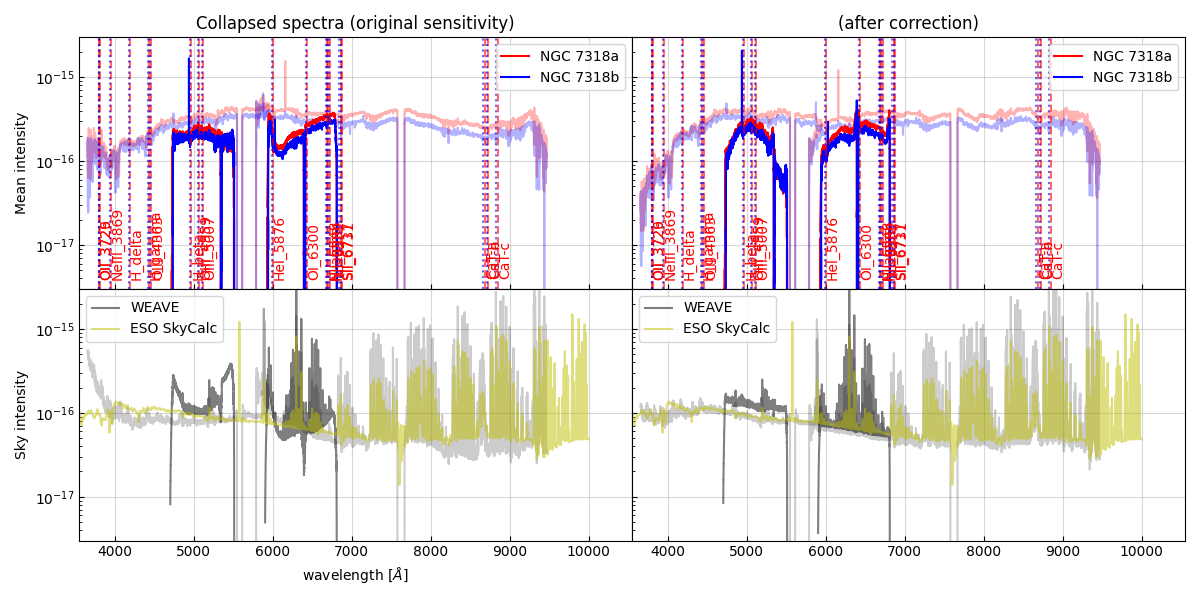

In [8]:
plt.close('spectra')
fig = plt.figure('spectra', figsize=(12, 6))
ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                  sharex=True, sharey=True,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 10550)


ax[0, 0].set_title(r'Collapsed spectra (original sensitivity)')
ax[0, 0].set_ylabel(r'Mean intensity')

ax[0, 0].plot(LR_red.wavelength, LR_red.ngc7318a, 'r-', alpha=.3)
ax[0, 0].plot(LR_blue.wavelength, LR_blue.ngc7318a, 'r-', alpha=.3)
ax[0, 0].plot(LR_red.wavelength, LR_red.ngc7318b, 'b-', alpha=.3)
ax[0, 0].plot(LR_blue.wavelength, LR_blue.ngc7318b, 'b-', alpha=.3)

ax[0, 0].plot(HR_red.wavelength, HR_red.ngc7318a, 'r-', label='NGC 7318a')
ax[0, 0].plot(HR_blue.wavelength, HR_blue.ngc7318a, 'r-')
ax[0, 0].plot(HR_red.wavelength, HR_red.ngc7318b, 'b-', label='NGC 7318b')
ax[0, 0].plot(HR_blue.wavelength, HR_blue.ngc7318b, 'b-')

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    xmin, xmax = ax[0, 0].get_xlim()
    ymin, ymax = ax[0, 0].get_ylim()
    x0 = lines[line][0]*(1+redshift_a)
    if x0 > xmin and x0 < xmax:
        ax[0, 0].annotate(line, xy=(x0, .05), xycoords=('data', 'axes fraction'), rotation=90, color='r')
    #print(lines[line][0]*(1+redshift_a), ymin, line)

ax[0, 1].set_title(r'(after correction)')

ax[0, 1].plot(LR_red.wavelength, LR_red.ngc7318a*LR_red.correction, 'r-', alpha=.3)
ax[0, 1].plot(LR_blue.wavelength, LR_blue.ngc7318a*LR_blue.correction, 'r-', alpha=.3)
ax[0, 1].plot(LR_red.wavelength, LR_red.ngc7318b*LR_red.correction, 'b-', alpha=.3)
ax[0, 1].plot(LR_blue.wavelength, LR_blue.ngc7318b*LR_blue.correction, 'b-', alpha=.3)

ax[0, 1].plot(HR_red.wavelength, HR_red.ngc7318a*HR_red.correction, 'r-', label='NGC 7318a')
ax[0, 1].plot(HR_blue.wavelength, HR_blue.ngc7318a*HR_blue.correction, 'r-')
ax[0, 1].plot(HR_red.wavelength, HR_red.ngc7318b*HR_red.correction, 'b-', label='NGC 7318b')
ax[0, 1].plot(HR_blue.wavelength, HR_blue.ngc7318b*HR_blue.correction, 'b-')

for line in lines:
    ax[0, 1].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 1].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    xmin, xmax = ax[0, 0].get_xlim()
    ymin, ymax = ax[0, 0].get_ylim()
    x0 = lines[line][0]*(1+redshift_a)
    if x0 > xmin and x0 < xmax:
        ax[0, 1].annotate(line, xy=(x0, .05), xycoords=('data', 'axes fraction'), rotation=90, color='r')
    #print(line, lines[line][0]*(1+redshift_a), ymin)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


ax[1, 0].set_ylabel(r'Sky intensity')

ax[1, 0].plot(LR_red.wavelength, LR_red.sky, 'k-', alpha=.2)
ax[1, 0].plot(LR_blue.wavelength, LR_blue.sky, 'k-', alpha=.2)
ax[1, 0].plot(HR_red.wavelength, HR_red.sky, 'k-', alpha=.5)
ax[1, 0].plot(HR_blue.wavelength, HR_blue.sky, 'k-', alpha=.5, label='WEAVE')
ax[1, 0].plot(wavelength_SkyCalc, 4.5*intensity_SkyCalc, 'y-', alpha=.5, label='ESO SkyCalc')

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)

ax[1, 1].plot(LR_red.wavelength, LR_red.sky*LR_red.correction, 'k-', alpha=.2)
ax[1, 1].plot(LR_blue.wavelength, LR_blue.sky*LR_blue.correction, 'k-', alpha=.2)
ax[1, 1].plot(HR_red.wavelength, HR_red.sky*HR_red.correction, 'k-', alpha=.5)
ax[1, 1].plot(HR_blue.wavelength, HR_blue.sky*HR_blue.correction, 'k-', alpha=.5, label='WEAVE')
ax[1, 1].plot(wavelength_SkyCalc, 4.5*intensity_SkyCalc, 'y-', alpha=.5, label='ESO SkyCalc')

ax[1, 1].legend()

plt.show()

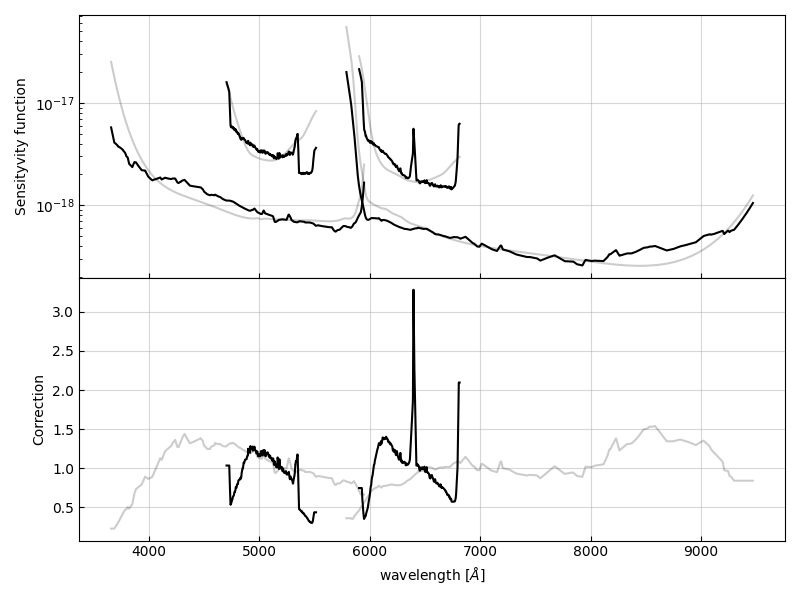

In [9]:
plt.close('correction')
fig = plt.figure('correction', figsize=(8, 6))
ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

ax[0, 0].set_ylabel(r'Sensityvity function')
for cube in [LR_red, LR_blue, HR_red, HR_blue]:
    ax[0, 0].plot(cube.wavelength, cube.sensitivity, 'k-', alpha=.2)
    ax[0, 0].plot(cube.wavelength, cube.sensitivity*cube.correction, 'k-')

ax[1, 0].set_ylabel(r'Correction')
for cube in [LR_red, LR_blue]:
    ax[1, 0].plot(cube.wavelength, cube.correction, 'k-', alpha=.2)
for cube in [HR_red, HR_blue]:
    ax[1, 0].plot(cube.wavelength, cube.correction, 'k-')

'''

ax[2, 0].plot(wavelength_blue, sensitivity_function_blue, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red, sensitivity_function_red, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue, sensitivity_function_blue*correction_blue, 'b-')
ax[2, 0].plot(wavelength_red, sensitivity_function_red*correction_red, 'r-')

ax[2, 0].plot(wavelength_blue_HR, sensitivity_function_blue_HR, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red_HR, sensitivity_function_red_HR, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue_HR, sensitivity_function_blue_HR*correction_blue_HR, 'b-')
ax[2, 0].plot(wavelength_red_HR, sensitivity_function_red_HR*correction_red_HR, 'r-')
'''

ax[0, -1].set_yscale('log')
#ax[1, -1].set_yscale('log')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
#ax[-1, -1].set_xlim(3550, 10550)

plt.show()


In [10]:
'''
plt.close('corrected')
fig = plt.figure('corrected', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra, after correction')
ax[0, 0].set_ylabel(r'Mean intensity')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red*correction_red, 'k-', label='bright region')
ax[0, 0].plot(wavelength_blue, SED_bright_blue*correction_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red*correction_red, 'r-', label='faint region')
ax[0, 0].plot(wavelength_blue, SED_faint_blue*correction_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


ax[1, 0].set_ylabel(r'Sky intensity')
#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
#ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, 4*intensity_SkyCalc, 'k-', label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red*correction_red, 'r-', alpha=.2, label='LR (red)')
ax[1, 0].plot(wavelength_blue, sky_blue*correction_blue, 'b-', alpha=.2, label='LR (blue)')
ax[1, 0].plot(wavelength_red_HR, sky_red_HR*correction_red_HR, 'r-', alpha=.5, label='HR (red)')
ax[1, 0].plot(wavelength_blue_HR, sky_blue_HR*correction_blue_HR, 'b-', alpha=.5, label='HR (blue)')


ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Sensityvity function')

ax[2, 0].plot(wavelength_blue, sensitivity_function_blue, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red, sensitivity_function_red, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue, sensitivity_function_blue*correction_blue, 'b-')
ax[2, 0].plot(wavelength_red, sensitivity_function_red*correction_red, 'r-')

ax[2, 0].plot(wavelength_blue_HR, sensitivity_function_blue_HR, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red_HR, sensitivity_function_red_HR, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue_HR, sensitivity_function_blue_HR*correction_blue_HR, 'b-')
ax[2, 0].plot(wavelength_red_HR, sensitivity_function_red_HR*correction_red_HR, 'r-')

ax[2, -1].set_yscale('log')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 10550)

plt.show()
'''


"\nplt.close('corrected')\nfig = plt.figure('corrected', figsize=(8, 8))\nax = fig.subplots(nrows=3, ncols=1, squeeze=False,\n                  sharex=True, sharey=False,\n                  gridspec_kw={'hspace': 0, 'wspace': 0}\n                 )\nfor axis in ax.flatten():\n    axis.tick_params(which='both', direction='in')\n    axis.grid(alpha=.5)\nfig.set_tight_layout(True)\n\nax[0, 0].set_title(r'Collapsed spectra, after correction')\nax[0, 0].set_ylabel(r'Mean intensity')\n#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\\AA$/... pixel?]')\n\nax[0, 0].plot(wavelength_red, SED_bright_red*correction_red, 'k-', label='bright region')\nax[0, 0].plot(wavelength_blue, SED_bright_blue*correction_blue, 'k-')\n\nax[0, 0].plot(wavelength_red, SED_faint_red*correction_red, 'r-', label='faint region')\nax[0, 0].plot(wavelength_blue, SED_faint_blue*correction_blue, 'r-')\n\nax[0, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')\nax[0, 0].plot(wavelength_blue, sk

In [11]:
'''
np.savetxt("sensitivity_function_blue.txt", np.vstack((wavelength_blue, sensitivity_function_blue*correction_blue)).T, fmt='%.2f %.4e')
np.savetxt("sensitivity_function_red.txt", np.vstack((wavelength_red, sensitivity_function_red*correction_red)).T, fmt='%.2f %.4e')
'''


'\nnp.savetxt("sensitivity_function_blue.txt", np.vstack((wavelength_blue, sensitivity_function_blue*correction_blue)).T, fmt=\'%.2f %.4e\')\nnp.savetxt("sensitivity_function_red.txt", np.vstack((wavelength_red, sensitivity_function_red*correction_red)).T, fmt=\'%.2f %.4e\')\n'